# Classificando com Deep Learning

In [1]:
#Bibliotecas importantes
import arcpy
from arcpy import env
import os 
from arcpy.ia import *
env.overwriteOutput = True

In [2]:
#Diretorio de workspace
workspace = r"C:\SL_ARCGIS_PRO\DL_CS_PYTHON\raster"

In [3]:
#Diretório
out_poligon = os.path.join(workspace, 'poligons') #polígono usado como input para gerar feature de amostras
classificada = os.path.join(workspace, 'classified.tif') #imagem classificada com ML

In [4]:
#Conversão de raster classificado com ML para feature de classes
arcpy.conversion.RasterToPolygon(classificada,
                                     out_poligon,
                                     "SIMPLIFY",
                                     "Classvalue",
                                     "SINGLE_OUTER_PART",
                                     None)

<Result 'C:\\SL_ARCGIS_PRO\\DL_CS_PYTHON\\raster\\poligons.shp'>

In [5]:
#Imagem para classificar
input_imagem = os.path.join(workspace, 'rgb_mdr_utm.tif')
out_amostras = os.path.join(workspace, 'amostra') #pasta contendo os dados para treinamento do modelo

In [6]:
arcpy.ia.ExportTrainingDataForDeepLearning(input_imagem ,
                                           out_amostras ,
                                           out_poligon,
                                           "TIFF",
                                           256, 256, 128, 128,
                                           "ONLY_TILES_WITH_FEATURES",
                                           "Classified_Tiles",
                                           0, "gridcode",
                                           0, None, 0,
                                           "MAP_SPACE",
                                           "PROCESS_AS_MOSAICKED_IMAGE",
                                           "NO_BLACKEN",
                                           "FIXED_SIZE",
                                           None)

<geoprocessing server result object object at 0x0000019E8B7AFC60>

## Treinando o modelo

In [7]:
from arcgis.learn import *

In [8]:
#ler as amostras
data = prepare_data(out_amostras, 
                    batch_size= 8, 
                    dataset_type="Classified_Tiles", 
                    chip_size = 256)

In [9]:
#Configurando modelo
model = UnetClassifier(data, backbone = "resnet34")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\silvio.lemos/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|##########| 83.3M/83.3M [00:10<00:00, 8.00MB/s]


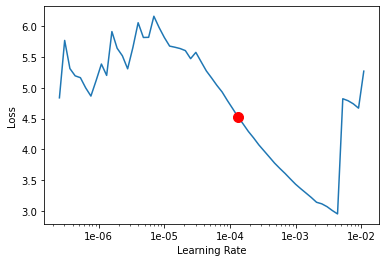

Learning Rate: 0.00013182567385564074


In [10]:
#Learning Rate
lr = model.lr_find()
print("Learning Rate:",lr)

In [11]:
model.fit(10, lr =lr) #parametros da quantiadades de épocas

epoch     train_loss  valid_loss  accuracy  dice      time    
0         0.832062    1.191561    0.718678  0.613033  02:13     
1         0.524927    0.670003    0.760950  0.669667  02:04     
2         0.463737    0.591145    0.771227  0.694009  02:11     
3         0.451031    0.659513    0.752863  0.672017  02:13     
4         0.373222    0.609554    0.788296  0.716040  02:05     
5         0.371196    0.461757    0.812541  0.744152  02:12     
6         0.348722    0.421212    0.816504  0.752908  02:20     
7         0.334810    0.714081    0.657831  0.563107  02:16     
8         0.310636    0.428624    0.809501  0.735374  02:15     
9         0.298769    0.500285    0.772336  0.697660  02:15     


In [12]:
model.per_class_metrics()

,NoData,30,40,70
precision,0.999931,0.937034,0.948012,0.684794
recall,0.999001,0.244215,0.822486,0.964277
f1,0.999466,0.387451,0.880799,0.800852


In [13]:
model.mIOU()

{'0': 0.9979383259624431, '30': 0.22883366436406286, '40': 0.7845030238547414, '70': 0.6663100432328128}

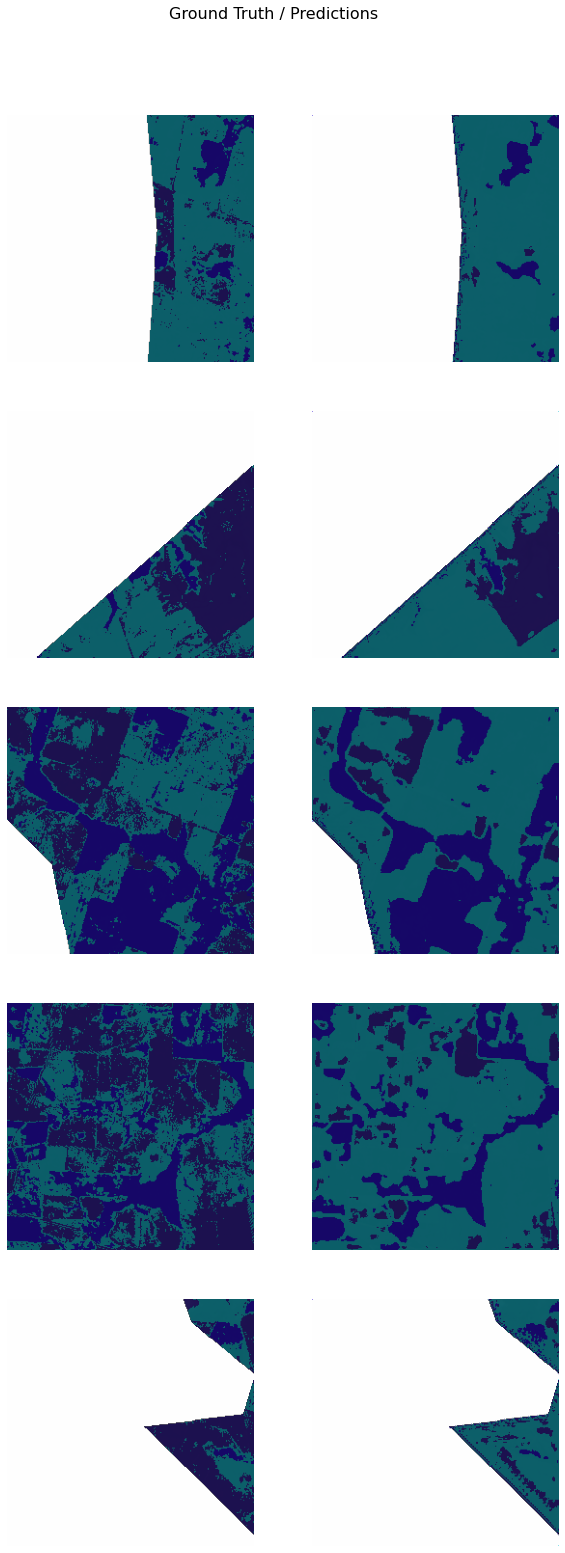

In [14]:
model.show_results()

In [15]:
#salvar modelo
model.save('model_UNET')

Computing model metrics...


WindowsPath('C:/SL_ARCGIS_PRO/DL_CS_PYTHON/raster/amostra/models/model_UNET')

## Classificando uma nova imagem

In [20]:
#Configurações de classificação
nova_imagem = os.path.join(workspace, 'aoi.tif')
modelo = os.path.join(workspace, 'amostra\models\model_UNET\model_UNET.dlpk')
parametros = "padding 56;batch_size 8;predict_background True;tile_size 256"

#Diretório de classificação
out_new_classified = r"C:\SL_ARCGIS_PRO\DL_CS_PYTHON\raster\predicao\imagem_Classify.tif"

In [21]:
with arcpy.EnvManager(processorType="GPU"):
    out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning(nova_imagem, modelo , parametros, "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(out_new_classified)